# Experiments 3:
### generating byte-to-integers representations derived from file body blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_2nd_block_bytes, convert_cat2num
from toolkit.models import Ffnn, Cnn, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 519.8767892054933


In [4]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [5]:
# we sample files whose size is larger than 16 kb
# this is to ensure we have 2 body blocks at least
df = df[df['type'].isin(CLASS_NAMES)]
df = df[df['size KB'] > 16]
df['type'].value_counts()

type
pdf     168373
html    110537
doc      52927
xls      45050
txt      42195
jpg      41034
ppt      39412
xml      13837
ps       12275
gif       8412
swf       2694
png       1356
Name: count, dtype: int64

In [6]:
# sample 12 file types
df = df.groupby('type').apply(
    lambda x: x if x.name == "png" else x.sample(n=min(len(x), 2000), random_state=42)
).reset_index(drop=True)

df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_22852\3309657051.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
png     1356
Name: count, dtype: int64

In [7]:
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["body_block_bytes"] = df["file"].apply(lambda file: get_2nd_block_bytes(os.path.join(base_dir, file)))
df["byte_integers"] = df["body_block_bytes"].apply(lambda byte_sequence: np.array([byte for byte in byte_sequence]))

In [8]:
byte_lengths = df["byte_integers"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        4096
1        4096
2        4096
3        4096
4        4096
         ... 
23351    4096
23352    4096
23353    4096
23354    4096
23355    4096
Name: byte_integers, Length: 23356, dtype: int64
all byte sequences of the same length: True


In [9]:
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))

In [10]:
df.sample(n=10)

,file,type,size KB,body_block_bytes,byte_integers,class
594,072136.doc,doc,90.500000,"b'os produtores e empresas locais, nacionais e...","[111, 115, 32, 112, 114, 111, 100, 117, 116, 1...",1
14928,689647.ps,ps,949.161133,b'nt [ 0.00 21.60 -21.60 0.00 0. 0.] make...,"[110, 116, 32, 91, 32, 32, 32, 48, 46, 48, 48,...",3
30,243508.doc,doc,39.000000,"b""dical School\rDepartment of Family Medicine ...","[100, 105, 99, 97, 108, 32, 83, 99, 104, 111, ...",1
20755,040563.xls,xls,237.500000,b'\x00\xfd\x00\n\x00\x00\x00\x19\x00\x0f\x00\n...,"[0, 253, 0, 10, 0, 0, 0, 25, 0, 15, 0, 10, 0, ...",4
7974,015600.jpg,jpg,55.364258,b'?\xd6\xe2x\xcc\xcf\xaf\x1ds\xa7\xe0t\xec\xf6...,"[63, 214, 226, 120, 204, 207, 175, 29, 115, 16...",8
11069,719727.png,png,103.920898,"b'\x0e\xc3\xa6,\xc3\xba\x97\x15=\x00\x06\xf2(\...","[14, 195, 166, 44, 195, 186, 151, 21, 61, 0, 6...",9
21876,585905.xml,xml,197.981445,b'Markings</ATA_Level_2_Description>\r\n ...,"[77, 97, 114, 107, 105, 110, 103, 115, 60, 47,...",12
16936,585914.swf,swf,52.397461,b'Rp6\xd5\xdd\xbdL\x92\xdc\xda>Ax\xe7q J\xfa\x...,"[82, 112, 54, 213, 221, 189, 76, 146, 220, 218...",6
13218,550535.ppt,ppt,5642.000000,b'>G\xb0\x0e\xa4\xe9\xff!\xd6\x862\xa6\xbb\xdb...,"[62, 71, 176, 14, 164, 233, 255, 33, 214, 134,...",5
192,031750.doc,doc,26.500000,b'y\rDirector for Enforcement & Compliance\r\x...,"[121, 13, 68, 105, 114, 101, 99, 116, 111, 114...",1


In [11]:
X = np.array([x for x in df["byte_integers"]])
y = np.array([y for y in df["class"]])

In [12]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (23356, 4096)
y shape:  (23356,)


In [13]:
# same ratio split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
print("X training shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X testing shape: ", X_test.shape, "\n")
print("y training shape: ", y_train.shape)
print("y validation shape: ", y_val.shape)
print("y testing shape: ", y_test.shape)

X training shape:  (14947, 4096)
X validation shape:  (3737, 4096)
X testing shape:  (4672, 4096) 

y training shape:  (14947,)
y validation shape:  (3737,)
y testing shape:  (4672,)


## 2. Models Training and Evaluation

### Feed Forward Neural Network

In [15]:
ffnn = Ffnn(timesteps=4096, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096, 256)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │     6,815,757 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,849,165 (26.13 MB)

 Trainable params: 6,849,165 (26.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 151s 322ms/step - accuracy: 0.1951 - loss: 111.0603 - val_accuracy: 0.2927 - val_loss: 2.0723
Epoch 2/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 145s 310ms/step - accuracy: 0.3871 - loss: 1.9534 - val_accuracy: 0.2836 - val_loss: 1.9971
Epoch 3/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 147s 315ms/step - accuracy: 0.4798 - loss: 1.6585 - val_accuracy: 0.2935 - val_loss: 1.9375
Epoch 4/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 150s 321ms/step - accuracy: 0.5353 - loss: 1.4438 - val_accuracy: 0.3040 - val_loss: 1.9556


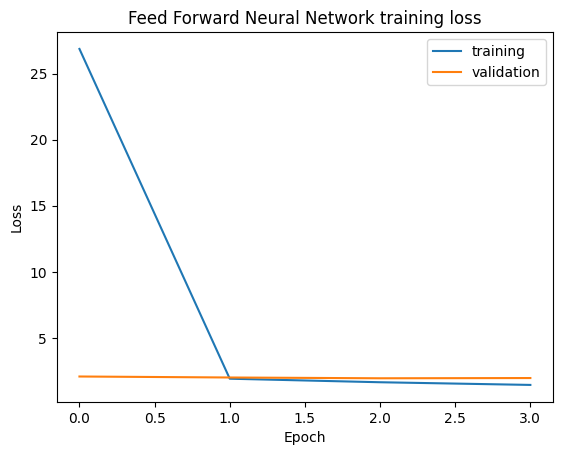

In [17]:
ffnn.plot_learning_curves()

In [18]:
ffnn_pred = ffnn.predict(X_test)

146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step


In [19]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.31598114824335904.
precision	0.28364038996795965.
recall		0.3109512515338403.
f1-score	0.26893204290345174.


In [20]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.61      0.26      0.36       357
         pdf       0.31      0.38      0.34       405
          ps       0.00      0.00      0.00       434
         xls       0.70      0.56      0.62       383
         ppt       0.26      0.16      0.20       392
         swf       0.29      0.31      0.30       409
         gif       0.62      0.63      0.63       440
         jpg       0.19      0.23      0.21       389
         png       0.19      0.19      0.19       265
        html       0.00      0.00      0.00       395
         txt       0.22      1.00      0.37       403
         xml       0.00      0.00      0.00       396

    accuracy                           0.32      4668
   macro avg       0.28      0.31      0.27      4668
weighted avg       0.28      0.32      0.27      4668



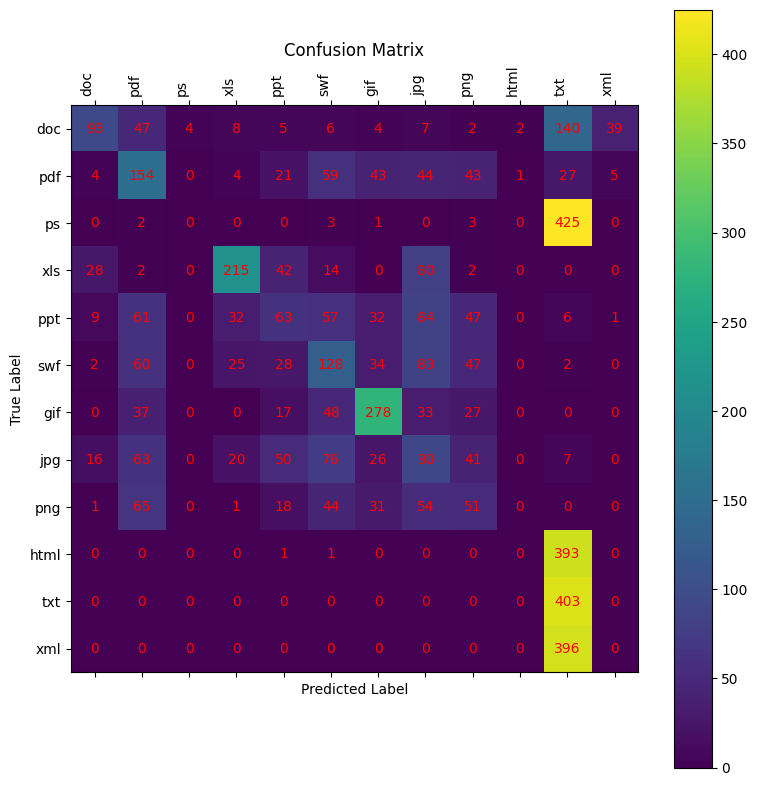

In [21]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

### Convolutional Neural Network

In [22]:
cnn = Cnn(timesteps=4096, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4094, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2047, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2045, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1022, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 130816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │     1,700,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725,581 (6.58 MB)

 Trainable params: 1,725,581 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
cnn_history = cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 74s 157ms/step - accuracy: 0.1548 - loss: 64.2129 - val_accuracy: 0.2102 - val_loss: 2.2777
Epoch 2/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - accuracy: 0.2789 - loss: 2.1156 - val_accuracy: 0.3037 - val_loss: 1.9741
Epoch 3/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 74s 158ms/step - accuracy: 0.4070 - loss: 1.6892 - val_accuracy: 0.3420 - val_loss: 1.9202
Epoch 4/4
467/467 ━━━━━━━━━━━━━━━━━━━━ 73s 157ms/step - accuracy: 0.4706 - loss: 1.5259 - val_accuracy: 0.3072 - val_loss: 2.1193


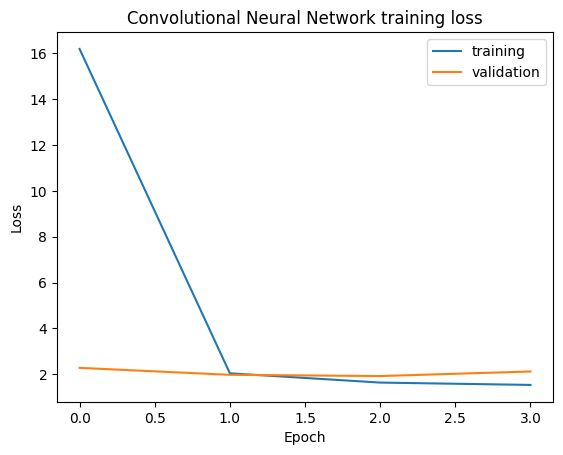

In [24]:
cnn.plot_learning_curves()

In [25]:
cnn_pred = cnn.predict(X_test)

146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


In [26]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.3286203941730934.
precision	0.3429068851715667.
recall		0.3207326631358976.
f1-score	0.30897416402902705.


In [27]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.51      0.28      0.36       357
         pdf       0.26      0.26      0.26       405
          ps       0.27      0.79      0.40       434
         xls       0.69      0.64      0.67       383
         ppt       0.24      0.14      0.17       392
         swf       0.34      0.29      0.31       409
         gif       0.46      0.46      0.46       440
         jpg       0.21      0.19      0.20       389
         png       0.16      0.20      0.18       265
        html       0.35      0.34      0.35       395
         txt       0.24      0.16      0.20       403
         xml       0.38      0.09      0.15       396

    accuracy                           0.33      4668
   macro avg       0.34      0.32      0.31      4668
weighted avg       0.35      0.33      0.31      4668



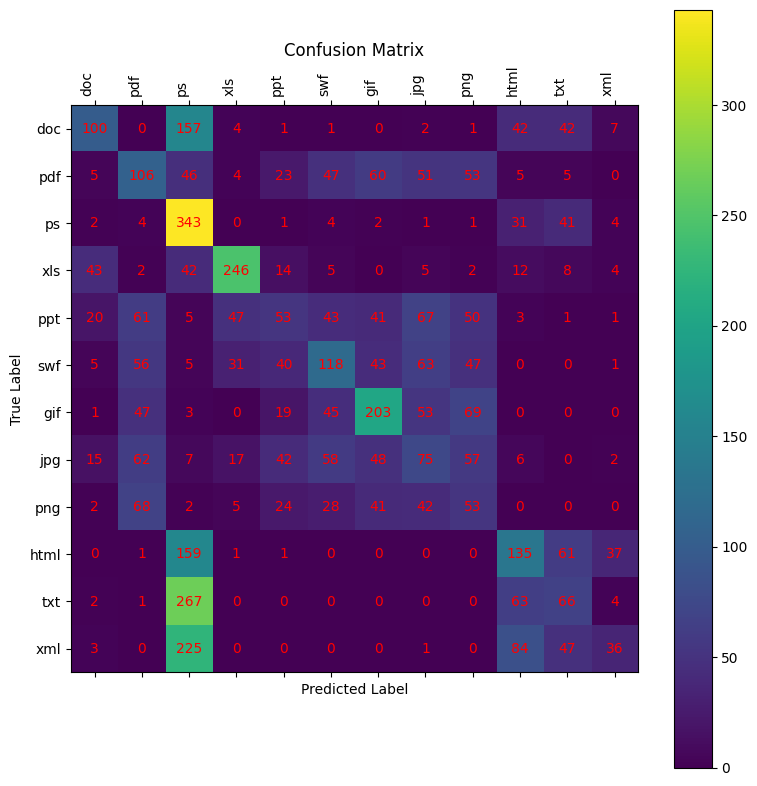

In [28]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [29]:
gru = Gru(timesteps=4096, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
gru_history = gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1370s 3s/step - accuracy: 0.2751 - loss: 1.9785 - val_accuracy: 0.4794 - val_loss: 1.3174
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1324s 3s/step - accuracy: 0.5269 - loss: 1.2348 - val_accuracy: 0.5736 - val_loss: 1.0542
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1347s 3s/step - accuracy: 0.6049 - loss: 1.0362 - val_accuracy: 0.6227 - val_loss: 0.9949
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1436s 3s/step - accuracy: 0.6578 - loss: 0.9165 - val_accuracy: 0.6776 - val_loss: 0.8206
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1569s 3s/step - accuracy: 0.6846 - loss: 0.8359 - val_accuracy: 0.6966 - val_loss: 0.7965
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1774s 4s/step - accuracy: 0.7144 - loss: 0.7800 - val_accuracy: 0.7142 - val_loss: 0.7453
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1372s 3s/step - accuracy: 0.7384 - loss: 0.7242 - val_accuracy: 0.7590 - val_loss: 0.6668
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1400s 3s/step - accuracy: 0.7575 - loss: 0.6801 - 

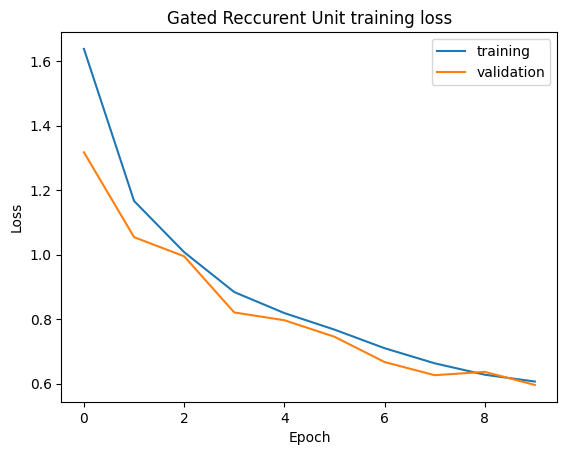

In [31]:
gru.plot_learning_curves()

In [32]:
gru_pred = gru.predict(X_test)

146/146 ━━━━━━━━━━━━━━━━━━━━ 66s 446ms/step


In [33]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.7718508997429306.
precision	0.776632321662782.
recall		0.7722137008500223.
f1-score	0.7589342449886911.


In [34]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.89      0.94      0.91       357
         pdf       0.96      0.86      0.91       405
          ps       0.94      0.94      0.94       434
         xls       0.92      0.96      0.94       383
         ppt       0.61      0.25      0.36       392
         swf       0.63      0.40      0.49       409
         gif       0.79      0.81      0.80       440
         jpg       0.74      0.87      0.80       389
         png       0.35      0.76      0.48       265
        html       0.77      0.83      0.80       395
         txt       0.81      0.81      0.81       403
         xml       0.91      0.83      0.87       396

    accuracy                           0.77      4668
   macro avg       0.78      0.77      0.76      4668
weighted avg       0.79      0.77      0.77      4668



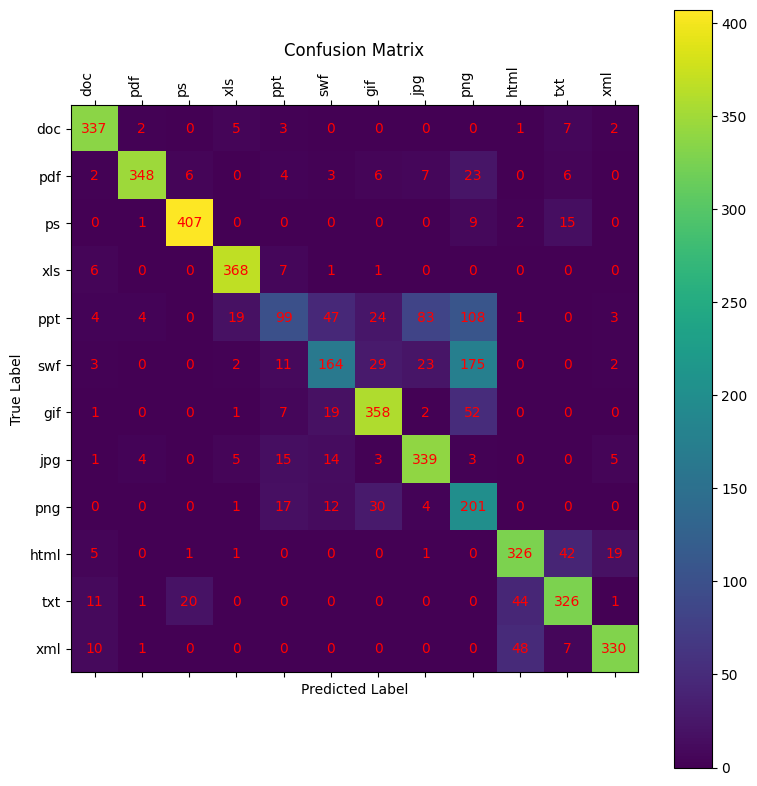

In [35]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [36]:
lstm = Lstm(timesteps=4096, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
lstm_history = lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1248s 3s/step - accuracy: 0.2642 - loss: 2.0120 - val_accuracy: 0.3787 - val_loss: 1.5912
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1259s 3s/step - accuracy: 0.4227 - loss: 1.4900 - val_accuracy: 0.4582 - val_loss: 1.3850
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1286s 3s/step - accuracy: 0.4687 - loss: 1.3680 - val_accuracy: 0.5046 - val_loss: 1.2809
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1288s 3s/step - accuracy: 0.4922 - loss: 1.3275 - val_accuracy: 0.4963 - val_loss: 1.2757
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1296s 3s/step - accuracy: 0.5341 - loss: 1.2245 - val_accuracy: 0.5640 - val_loss: 1.1448
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1306s 3s/step - accuracy: 0.5796 - loss: 1.1158 - val_accuracy: 0.6111 - val_loss: 1.0355
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1313s 3s/step - accuracy: 0.6050 - loss: 1.0501 - val_accuracy: 0.6170 - val_loss: 1.0148
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1297s 3s/step - accuracy: 0.6320 - loss: 0.9924 - 

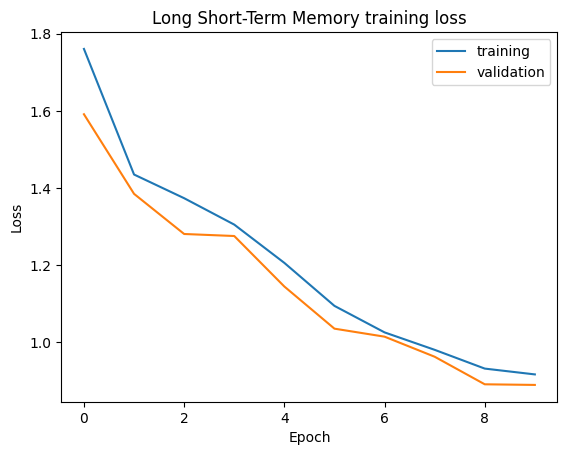

In [38]:
lstm.plot_learning_curves()

In [39]:
lstm_pred = lstm.predict(X_test)

146/146 ━━━━━━━━━━━━━━━━━━━━ 101s 692ms/step


In [40]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.6865895458440445.
precision	0.6819243001303789.
recall		0.6779982553390531.
f1-score	0.6753947570551845.


In [41]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.84      0.81      0.82       357
         pdf       0.90      0.83      0.86       405
          ps       0.79      0.91      0.85       434
         xls       0.90      0.91      0.90       383
         ppt       0.43      0.25      0.31       392
         swf       0.44      0.66      0.53       409
         gif       0.71      0.66      0.69       440
         jpg       0.68      0.69      0.69       389
         png       0.43      0.40      0.41       265
        html       0.61      0.61      0.61       395
         txt       0.69      0.68      0.68       403
         xml       0.78      0.73      0.75       396

    accuracy                           0.69      4668
   macro avg       0.68      0.68      0.68      4668
weighted avg       0.69      0.69      0.68      4668



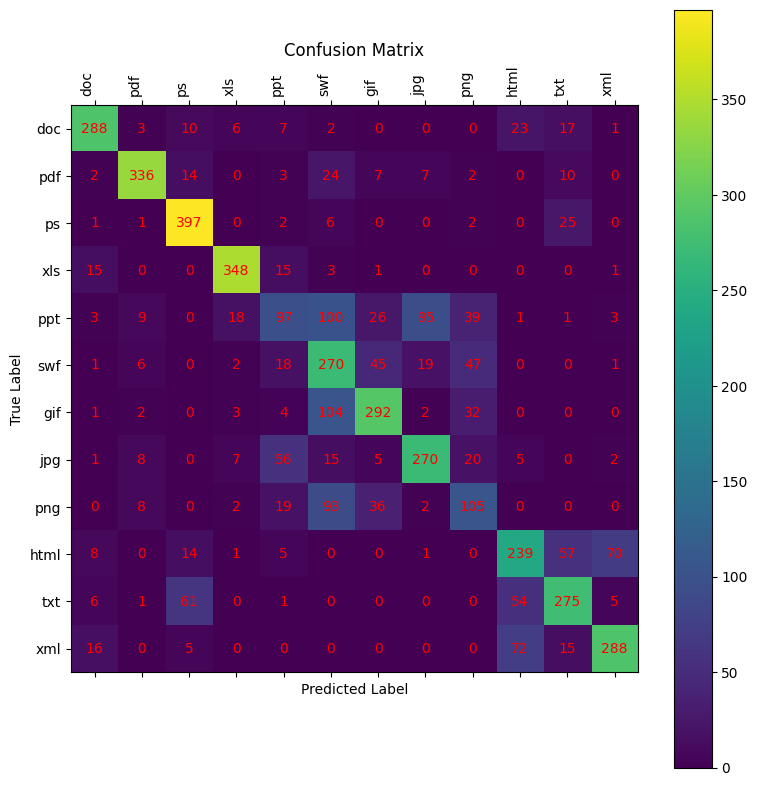

In [42]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)